## Calculate freeze-thaw days for NA-CORDEX

This notebook calculates ensemble statistics of annual freeze-thaw days for the NA-CORDEX dataset and saves the results in NetCDF format.

All the data come from the 50-km (NAM-44i) simulations.  Freeze-thaw days are days when the minimum temperature is below -1C, and the maximum temperatre is above 0C.  We calculate freeze-thaw days from daily data, then sum them over years.

The runs are divided into three ensembles: the RCP4.5 runs, the corresponding RCP8.5 runs, and the RCP8.5 runs that don't have a matching RCP4.5 run.  (There are no RCP4.5 runs without a corresponding 8.5 run.)  We then calculate the ensemble min, max, mean, and median at each location for each year.

### TODO items
* output ensemble statistics to netcdf
* add cells (and switch controls) for reading from:
** netcdf on glade
** zarr on stratus object store
** zarr on aws
* use bias-corrected data instead of raw data (not yet available in zarr format)

In [1]:
import time
starttime = time.time()

In [2]:
%%time

import xarray as xr
import numpy as np

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import os

import pprint
import json

CPU times: user 667 ms, sys: 198 ms, total: 866 ms
Wall time: 869 ms


### Use Dask to Speed up Computations

In [3]:
%%time

import dask
from ncar_jobqueue import NCARCluster

## Processes is processes PER CORE.  Memory is total memory split across jobs.

## NA-CORDEX zarr store chunks are around 200 MB, so they should fit easily into the 
## per-core memory allocation.  The total memory request could likely be reduced,
## but you do need a fair amount for overhead of task graph, data buffering, etc.

num_jobs = 30
walltime = "4:00:00"
cluster = NCARCluster(cores=num_jobs, processes=1, memory='90GB', project='P86850057', walltime=walltime)
cluster.scale(jobs=num_jobs)

from distributed import Client
from distributed.utils import format_bytes
client = Client(cluster)
cluster

CPU times: user 434 ms, sys: 232 ms, total: 666 ms
Wall time: 11.1 s


In [4]:
## silence warnings about large chunks
dask.config.set({'array.slicing.split_large_chunks': False})

## propagate data attributes during operations ?
## xr.set_options(keep_attrs=True)

## Read in data from zarr stores

We need two different variables (tmin and tmax) and two different scenarios (rcp45 and rcp85) for this analysis, so we need to read from four different zarr stores.  (We're using the concatenated stores, which contain both historical and future data, so we don't need to worry about that.)

We're going to combine those zarr stores into a single xarray `Dataset` in order to simplify the code later on.  We can add two different variables from the same scenario to a single dataset because they have the same structure.  However, the set of RCM-GCM pairings (`member_id` dimension) varies by scenario, so to combine the data from different scenarios, we use `xarray.concat()` to do an outer join and create a new dimension `scen` for the scenario.  The resuting dataset will have a number of empty elements for RCM-GCM pairings that don't exist in both scenarios, but xarray handles that gracefully.

In [5]:
%%time

indir  = '/glade/scratch/bonnland/na-cordex/zarr-publish'

## zarrfiles are named {var}.{scenario}.day.{grid}.{bc}.zarr
zarr = "day.NAM-44i.raw.zarr"

## dict to rename member_id dimension for better plot readability
alias = {'member_id':'model'}

## iterating over scenarios and variables
scenarios = ("rcp45", "rcp85")

dslist = list()


for scen in scenarios:
    ds = xr.Dataset()
    for var in ("tmax","tmin"):
        zarrfile = indir + "/" + var + ".hist-" + scen + "." + zarr
        ds[var] = xr.open_zarr(zarrfile, consolidated=True)[var].rename(alias)
    dslist.append(ds)
    del ds
    
## Need to make scenarios tuple into a numpy array to use it as a coordinate variable
scenarr = np.array(scenarios, dtype="object")
    
ds = xr.concat(dslist, "scen").assign_coords({"scen": scenarr})


CPU times: user 327 ms, sys: 33.3 ms, total: 361 ms
Wall time: 349 ms


In [6]:
# Check that resulting data cube looks reasonable

ds

,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,23704 Tasks,5376 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,23704 Tasks,5376 Chunks
Type,float32,numpy.ndarray


### Identify ensembles

In [7]:
## Identify the RCM-GCM pairs in each ensemble while we still have them handily
## separated by scenario in dslist:

ens_rcp45 = set(dslist[0].model.to_dict()["data"])
ens_rcp85 = set(dslist[1].model.to_dict()["data"])
ens_pair = list(ens_rcp85 & ens_rcp45)
ens_solo = list(ens_rcp85 - ens_rcp45)

print("paired:", ens_pair, "\n")
print("solo:", ens_solo, "\n")

## The third case (ens_rcp45 - ens_rcp85) is empty

paired: ['EC-EARTH.RCA4', 'CanESM2.CRCM5-UQAM', 'CanESM2.CanRCM4', 'MPI-ESM-LR.CRCM5-UQAM', 'EC-EARTH.HIRHAM5', 'CanESM2.RCA4'] 

solo: ['MPI-ESM-LR.RegCM4', 'MPI-ESM-MR.CRCM5-UQAM', 'HadGEM2-ES.RegCM4', 'GFDL-ESM2M.RegCM4', 'GEMatm-MPI.CRCM5-UQAM', 'GEMatm-Can.CRCM5-UQAM', 'GFDL-ESM2M.WRF', 'HadGEM2-ES.WRF', 'MPI-ESM-LR.WRF'] 



### Plot a single timestep to check that results look reasonable

CPU times: user 10.2 s, sys: 1.54 s, total: 11.7 s
Wall time: 9min 43s


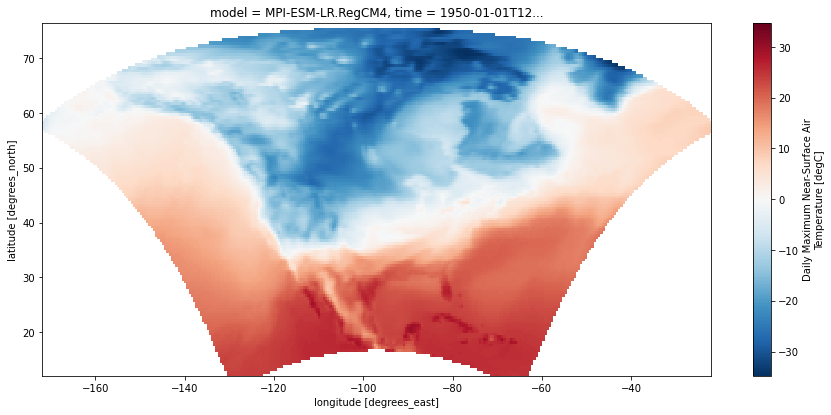

In [8]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
date = "1950-01-01"
scen = "rcp85"

slice = ds['tmax'].sel(model=sim, time=date, scen=scen)

slice.plot(figsize=(15,6.5))

## Calculate freeze-thaw days from tmin & tmax

Different sources use different thresholds for defining freeze-thaw days, so these are adjustable parameters defaulting to -1 and 0 C.

In [9]:
## todo: add units parameter & check units attribute on inputs
## todo: mask missing data in inputs

def freezethaw(tmin, tmax, freeze_temp=-1, thaw_temp=0):
    """
    Calculate freeze-thaw days where tmin < freezing and tmax > freezing
    
    Params:
        tmin, tmax: two xarray DataArrays daily min & max temperatures
        freeze_temp: threshold for tmin; defaults to -1 (units assumed degC)
        thaw_temp: threshold for tmax; defaults to 0 (units assumed degC)
    """
    
    result = (tmin < freeze_temp) & (tmax > thaw_temp)
    
    ## add 0*inputs to cast to float and mask missing value locations
    result = result + tmin * 0 + tmax * 0
    
    ## update attributes - units, longname, stdname
##    result.attr?

    return result    

## Set up calculation

In [10]:
## This step only constructs the task graph.
## The computation doesn't happen until needed or explicitly called.

ds["ftdays"] = freezethaw(ds["tmin"], ds["tmax"])

## check strucutre of result
ds["ftdays"]

,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,83066 Tasks,5376 Chunks
Type,float32,numpy.ndarray


### Plot a single timestep to check that results look reasonable

CPU times: user 145 ms, sys: 11.5 ms, total: 157 ms
Wall time: 1.25 s


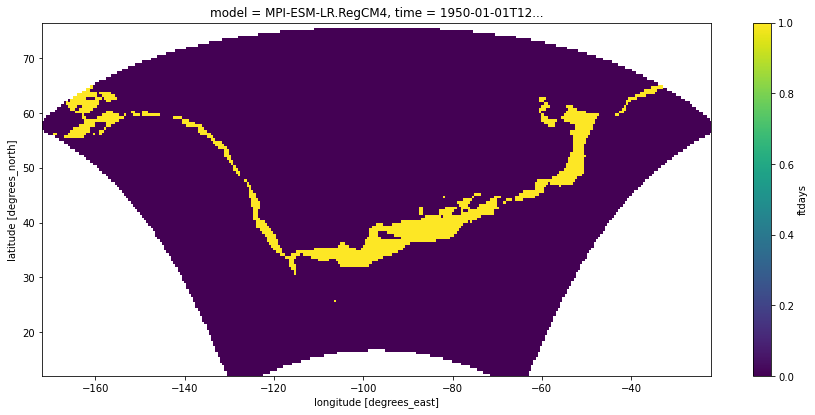

In [11]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
date = "1950-01-01"
scen = "rcp85"

slice = ds["ftdays"].sel(model=sim, time=date, scen=scen)

slice.plot(figsize=(15,6.5))

## Aggregate to yearly totals

In [ ]:
annftdays = ds["ftdays"].groupby('time.year').sum('time', min_count=180)

annftdays

### Plot a single timestep to check that results look reasonable

In [ ]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
year = 1979
scen = "rcp85"

slice = annftdays.sel(model=sim, year=year, scen=scen)

slice.plot(figsize=(15,6.5))

## Calculate ensemble statistics

Split the data into three ensembles and calculate ensemble min, max, mean, and median.
The ensembles are the rcp45 runs, the corresponding rcp85 runs, and the rcp85 runs that do not have a matching rcp45 run.

In [ ]:
ensds = xr.Dataset()
ensds['e45pair'] = annftdays.sel(scen="rcp45", model=ens_pair).squeeze()
ensds['e85pair'] = annftdays.sel(scen="rcp85", model=ens_pair).squeeze()
ensds['e85solo'] = annftdays.sel(scen="rcp85", model=ens_solo).squeeze()

## rechunking needed by quantile() function below
ensds = ensds.chunk({"model": -1})

In [ ]:
ensds

In [ ]:
ensembles = list(ensds.keys())

estats = xr.Dataset()

for e in ensembles:
    estats[e + ".min"]  = ensds[e].min("model") #, skipna=False)
    estats[e + ".max"]  = ensds[e].max("model") #, skipna=False)
    estats[e + ".mean"] = ensds[e].mean("model") #, skipna=False)
    estats[e + ".p50"]  = ensds[e].quantile(q=0.5, dim="model") #, skipna=False)

estats = estats.drop_vars(("scen","quantile"))  ## drop incorrect scalar coordinates
estats

### Plot some test results

In [ ]:
%%time

estats['e45pair.p50'].sel(year=2050).plot(figsize=(15,6.5))

## Write results to netcdf

In [ ]:
%%time

outdir = '/glade/scratch/mcginnis/deloitte/canada/zarr/'  ## note trailing slash

# estats.to_netcdf(outdir+"ftdays.stats.ann.NAM-44i.raw.nc", format="NETCDF4_CLASSIC", 
#                unlimited_dims = "year")



In [ ]:
## Add a bunch of attributes to output files



In [ ]:
out = estats["e45pair.p50"].rename("ftdays")
out = out[1:5,:,:]



out.to_netcdf(path = outdir+"test.nc",
                format = "NETCDF4_CLASSIC",
                encoding = {'year' :{'dtype':'float32', '_FillValue':None},
                           'ftdays':{'dtype':'float32', '_FillValue':1e20},
                           'lat'   :{'dtype':'float32', '_FillValue':None},
                           'lon'   :{'dtype':'float32', '_FillValue':None}},
                unlimited_dims = 'year')
#, "_FillValue":1e20
#ftdays.stat.scen.pair|solo.ann.NAM-44i.bc.nc]



In [ ]:
# xarrayobject.to_netcdf("filepath")
# look at brian's zarrify notebook for metadata examples

In [ ]:
out

### Release the workers.

In [ ]:
#cluster.close()

In [ ]:
finishtime = time.time()

In [ ]:
print("runtime (m):")
(finishtime - starttime)/60